# Artificial Intelligence
# 464/664
# Assignment #6

## General Directions for this Assignment

00. We're using a Jupyter Notebook environment (tutorial available here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html),
01. Read the entire notebook before beginning your work, 
02. Output format should be exactly as requested (it is your responsibility to make sure notebook looks as expected on Gradescope),
03. Each helper function should be preceeded by documentation (Markdown cell),
04. No comments in the code; anything worth mentioning should be included in the documentation,
05. Use descriptive variable names,
06. Functions should do only one thing,
07. Check submission deadline on Gradescope, 
08. Rename the file to Last_First_assignment_6, 
09. Submit your notebook (as .ipynb, not PDF) using Gradescope, 
10. Do not submit any other files, and
11. **Do not use any AI/ML libraries, packages, such as pandas, scikit (numpy is fine)**

## Directions _not_ applicable for this Assignment:
* Do not use classes,
* Keep functions to 20 lines or less (including empty lines so do not add any),
* Each helper function should be followed by three assert-style unit tests.

## Before You Submit...

1. Re-read the general instructions provided above, and
2. Hit "Kernel"->"Restart & Run All".

## Decision Trees

For this assignment we will implement a Decision Tree using the ID3 Algorithm. The goal is classify a mushroom as either edible ('e') or poisonous ('p'). Dataset has been uploaded to Canvas. In case you'd like to learn more about it, here's the link to the repo: https://archive.ics.uci.edu/dataset/73/mushroom. 


Our  Decision Tree pipeline is as follows:


1) `cross_validate` will take data (supplied as folds using 10 fold cross validation) and do the following:
* For each setting of depth limit (the hyperparameter in decision trees, including 0)
* * and for each fold of data
* * * use `create_train_test` to split current fold into train and test
* * * call `train` to build and return a decision tree, 
* * * call `classify` to use the tree to get classifications,
* * * call `evaluate` to compare classifications to the actual answers (ground truth),
* * * Print the performance for that fold
* * Summarize the performance for that depth limit over all folds using `get_stats`


2) `pretty_print_tree(tree)` will print what the tree looks like when using the **entire** data set (no train/test split) with depth limit set to None.


All the code in this pipeline has been provided, except for a working `train` function. The `train` function currently returns a hard-coded tree from our lecture. Don't do that. Use ID3 to build your tree and use the depth limit to stop. When you're train function is complete, it should work for the lecture data, and mushrooms. Although `train` is terrible right now, pay attention to how the tree is structured.

In [1]:
import random
import math
import copy
from copy import deepcopy
from typing import List, Dict, Tuple, Callable

<a id="note"></a>

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Note</strong>
    <p>
        Let's start with our example from the 06-Nov lecture. Target variable is Safe?, which can be yes or no. Anything *_lecture refers to the dataset we walked through in class.  
    </p>
</div>

In [2]:
data_lecture = [['round','large','blue','no'],
['square','large','green','yes'],
['square','small','red','no'],
['round','large','red','yes'],
['square','small','blue','no'],
['round','small','blue','no'],
['round','small','red','yes'],
['square','small','green','no'],
['round','large','green','yes'],
['square','large','green','yes'],
['square','large','red','no'],
['square','large','green','yes'],
['round','large','red','yes'],
['square','small','red','no'],
['round','small','green','no']]

In [3]:
print(data_lecture[0]) # a record of data

['round', 'large', 'blue', 'no']


In [4]:
len(data_lecture)

15

In [5]:
attribute_names_lecture = ['shape', 
                      'size', 
                      'color']

<a id="create_folds"></a>
## create_folds


With n-fold cross validation, we divide our data set into n subgroups called "folds" and then use those folds for training and testing. For data set with 100 observations (or records), n set to 10 would have 10 observations in each fold.

* **data** List: a list (data_lecture, for instance)
* **n** int: number of folds


**returns** 
folds, which is a list of n items, where each item is a list containing a subgroup of xs

In [6]:
def create_folds(data: List, n: int) -> List[List[List]]:
    k, m = divmod(len(data), n)
    return list(data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [7]:
folds_lecture = create_folds(data=data_lecture, n=10)

In [8]:
len(folds_lecture)

10

In [9]:
print(folds_lecture[0])

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes']]


In [10]:
print(folds_lecture[1])

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes']]


<a id="create_train_test"></a>
## create_train_test


This function takes the n folds and returns the train and test sets. One of the n folds is used to test, the others are used for training.

* **folds** List[List[List]]: see `create_folds`
* **index** int: fold index that is used for testing


**returns** 
folds, which is a list of n items, where each item is a list containing a subgroup of xs

In [11]:
def create_train_test(folds: List[List[List]], index: int) -> Tuple[List[List], List[List]]:
    training = []
    test = []
    for i, fold in enumerate(folds):
        if i == index:
            test = fold
        else:
            training = training + fold
    return training, test

In [12]:
train_lecture, test_lecture = create_train_test(folds_lecture, 0) # test data is folds_lecture index 0

In [13]:
print(train_lecture)

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'blue', 'no'], ['round', 'small', 'blue', 'no'], ['round', 'small', 'red', 'yes'], ['square', 'small', 'green', 'no'], ['round', 'large', 'green', 'yes'], ['square', 'large', 'green', 'yes'], ['square', 'large', 'red', 'no'], ['square', 'large', 'green', 'yes'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'red', 'no'], ['round', 'small', 'green', 'no']]


In [14]:
print(test_lecture)

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes']]


In [15]:
train_lecture, test_lecture = create_train_test(folds_lecture, 1) # test data is folds_lecture index 1

In [16]:
print(train_lecture)

[['round', 'large', 'blue', 'no'], ['square', 'large', 'green', 'yes'], ['square', 'small', 'blue', 'no'], ['round', 'small', 'blue', 'no'], ['round', 'small', 'red', 'yes'], ['square', 'small', 'green', 'no'], ['round', 'large', 'green', 'yes'], ['square', 'large', 'green', 'yes'], ['square', 'large', 'red', 'no'], ['square', 'large', 'green', 'yes'], ['round', 'large', 'red', 'yes'], ['square', 'small', 'red', 'no'], ['round', 'small', 'green', 'no']]


In [17]:
print(test_lecture)

[['square', 'small', 'red', 'no'], ['round', 'large', 'red', 'yes']]


<a id="note"></a>

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's load the mushroom data.
    </p>
</div>

<a id="parse_data"></a>
## parse_data

Opens a file, splits on comma, and shuffles data before returning as a List of list. 

* **file_name** Str: filename for data


**returns** 
Data as a list of a list.

In [18]:
def parse_data(file_name: str) -> List[List]:
    data = []
    file = open(file_name, "r")
    for line in file:
        datum = [value for value in line.rstrip().split(",")]
        data.append(datum)
    random.shuffle(data)
    return data

In [19]:
data_mushroom = parse_data("agaricus-lepiota.data")

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Important</strong>
    <p>
        We're going to move the target column (mushroom edible or poisonous) to the last column to match the lecture's format, where Safe? was at the end.
    </p>
</div>

In [20]:
data_mushroom = [record[1:]+[record[0]] for record in data_mushroom]

In [21]:
len(data_mushroom)

8124

In [22]:
print(data_mushroom[0])

['k', 'y', 'n', 'f', 'f', 'f', 'c', 'n', 'b', 't', '?', 's', 'k', 'p', 'p', 'p', 'w', 'o', 'e', 'w', 'v', 'p', 'p']


In [23]:
attribute_names_mushroom = ['cap-shape',
                   'cap-surface',
                   'cap-color',
                   'bruises?',
                   'odor',
                   'gill-attachment',
                   'gill-spacing',
                   'gill-size',
                   'gill-color',
                   'stalk-shape',
                   'stalk-root',
                   'stalk-surface-above-ring',
                   'stalk-surface-below-ring',
                   'stalk-color-above-ring',
                   'stalk-color-below-ring',
                   'veil-type',
                   'veil-color',
                   'ring-number',
                   'ring-type',
                   'spore-print-color',
                   'population',
                   'habitat']

<a id="get_answers"></a>
## get_answers

This function extracts a list of the target values from data. The function assumes the target variable is the last column of the data.

* **data** List[List]: The data provided in a list of list format identical to the structure of `data_lecture` or `data_mushroom`


**returns** 
A list of the values of the target variable.

In [24]:
def get_answers(data):
    return [record[-1] for record in data]

In [25]:
assert get_answers([]) == []
assert get_answers(data_lecture) == ['no', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no']

<a id="get_mode"></a>
## get_mode

This function finds the mode of a list of items. 

* **answers** List: A list of items

**returns** 
The item that appears the most often in the list. 

In [26]:
def get_mode(answers):
    count_dict = {}
    for answer in answers:
        if answer in count_dict:
            count_dict[answer] = count_dict[answer] + 1
        else:
            count_dict[answer] = 1
    mode_count = max(count_dict.values())
    mode = [k for k, v in count_dict.items() if v == mode_count]
    return mode[0]

In [27]:
assert get_mode(['no', 'no', 'no', 'yes']) == 'no'
assert get_mode(['no', 'no', 'yes', 'yes']) == 'no'
assert get_mode(['no', 'yes', 'yes', 'yes']) == 'yes'

<a id="train"></a>
## train

This function takes training_data, attribute names, and the depth limit and returns the decision tree as a nested dictionary. If the depth is 0, a dictionary is not returned. Instead, the mode of the target values is returned (i.e., majority class). 

* **training_data** List[List]: The data
* **attribute_names** List: The attribute names of the data (22 for mushroom; size, shape, and color for the lecture)
* **depth_limit** int: The depth limit of the tree


**returns** 
* **dt** Dict: The trained decision tree using the ID3 algorithm (entropy, information gain). It is represented as a nested dictionary. The dictionary returned for the lecture is structured as below:

```
{
('size', 1, 'large'): 
    {('color', 2, 'blue'): 'no', 
     ('color', 2, 'green'): 'yes', 
     ('color', 2, 'red'): 
         {('shape', 0, 'round'): 'yes', 
          ('shape', 0, 'square'): 'no'}
     }, 
('size', 1, 'small'): 
     {('shape', 0, 'square'): 'no', 
      ('shape', 0, 'round'): 
          {('color', 2, 'blue'): 'no', 
           ('color', 2, 'red'): 'yes', 
           ('color', 2, 'green'): 'no'}
      }
}
```


Notice that the keys are tuples; for instance, ('size', 1, 'large') is a key. The key includes the attribute's name, column number in data, and value.


The function currently returns a hard-coded tree. Your implementation should replace this with a tree that is learned from the data using the ID3 algorithm. You do not have to assert test `train`, but it may be worthwhile to check that it can return the tree from the lecture once your implementation is in place.

In [28]:
# def train(training_data, attribute_names, depth_limit=None):
#     # Bad. Use ID3 to build a tree. Stop using the depth limit. 
#     if depth_limit == 0:
#         return 'no'
#     elif depth_limit == 1:
#         return {('size', 1, 'large'): 'yes', ('size', 1, 'small'): 'no'}
#     elif depth_limit == 2:
#         return {('size', 1, 'large'): {('color', 2, 'blue'): 'no', ('color', 2, 'green'): 'yes', ('color', 2, 'red'): 'yes'}, ('size', 1, 'small'): {('shape', 0, 'square'): 'no', ('shape', 0, 'round'): 'no'}}
#     else:
#         return {('size', 1, 'large'): {('color', 2, 'blue'): 'no', ('color', 2, 'green'): 'yes', ('color', 2, 'red'): {('shape', 0, 'round'): 'yes', ('shape', 0, 'square'): 'no'}}, ('size', 1, 'small'): {('shape', 0, 'square'): 'no', ('shape', 0, 'round'): {('color', 2, 'blue'): 'no', ('color', 2, 'red'): 'yes', ('color', 2, 'green'): 'no'}}}

<a id="calc_entropy"></a>

calc_entropy
This function computes the entropy of a given dataset, which measures the uncertainty or disorder in the dataset with respect to the class labels. It is a key concept used in decision tree algorithms, such as ID3, for determining the best splits in the data based on class distribution.

data List[List]: A list of data points, where each inner list represents a data point. The last element of each inner list corresponds to the class label (target variable).
Returns

entropy float: The computed entropy of the dataset, which quantifies the impurity or randomness of the class labels. Lower entropy indicates that the dataset is more homogeneous, while higher entropy indicates more diversity in the class labels.


In [29]:
def calc_entropy(data):
    counts = {}
    for row in data:
        lbl = row[-1]
        if lbl not in counts:
            counts[lbl] = 0
        counts[lbl] += 1
    entropy = 0
    n = len(data)
    for c in counts.values():
        p = c / n
        entropy -= p * math.log2(p)
    return entropy

In [30]:

# Test with a dataset where all rows have the same class label (entropy should be 0)
assert calc_entropy([[1, 'Red', 'A'], [2, 'Blue', 'A'], [3, 'Red', 'A'], [4, 'Blue', 'A']]) == 0.0

# Test with a dataset where the class distribution is perfectly balanced (entropy should be 1)
assert calc_entropy([[1, 'Red', 'A'], [2, 'Blue', 'B'], [3, 'Red', 'B'], [4, 'Blue', 'A']]) == 1.0

# Test with a dataset where there are more than two classes
assert calc_entropy([[1, 'Red', 'A'], [2, 'Blue', 'A'], [3, 'Green', 'B'], [4, 'Blue', 'B'], [5, 'Red', 'C']]) == 1.5219280948873622


<a id="calculate_information_gain"></a>

calculate_information_gain
This function calculates the information gain for a given attribute in the dataset. Information gain is a measure of the reduction in entropy or uncertainty about the class label after splitting the dataset based on an attribute. It is used in decision tree algorithms, such as ID3, to select the attribute that provides the most useful information for partitioning the data.

data List[List]: The dataset, where each inner list represents a data point, and the last element of each list is the class label (target variable).
attr_idx int: The index of the attribute (column) for which information gain is to be calculated.
Returns

info_gain float: The computed information gain for the specified attribute. This value represents the reduction in entropy after splitting the dataset based on the attribute. A higher value indicates a better attribute for splitting the data.

In [31]:
def calculate_information_gain(data, attr_idx):
    entropy_before = calc_entropy(data)
    attr_vals = set(row[attr_idx] for row in data)
    weighted_entropy = 0
    for val in attr_vals:
        subset = [row for row in data if row[attr_idx] == val]
        weighted_entropy += len(subset) / len(data) * calc_entropy(subset)
    return entropy_before - weighted_entropy


In [32]:
# Test 1: Simple dataset with clear information gain
data1 = [
    [1, 'Red', 'A'],
    [2, 'Blue', 'A'],
    [3, 'Red', 'B'],
    [4, 'Blue', 'B'],
    [5, 'Red', 'A']
]
# Expect information gain for splitting on the 'Color' attribute (index 1) to be non-zero
assert calculate_information_gain(data1, 1) > 0.0  # The expected information gain should be positive

# Test 2: Dataset where the attribute values are the same (no information gain)
data2 = [
    [1, 'Red', 'A'],
    [2, 'Red', 'A'],
    [3, 'Red', 'B'],
    [4, 'Red', 'A'],
    [5, 'Red', 'A']
]
# Expect information gain for splitting on the 'Color' attribute (index 1) to be zero
assert calculate_information_gain(data2, 1) == 0.0

# Test 3: Balanced class distribution with different attributes
data3 = [
    [1, 'Red', 'A'],
    [2, 'Red', 'B'],
    [3, 'Blue', 'A'],
    [4, 'Blue', 'B'],
    [5, 'Green', 'C']
]
# Expect information gain for splitting on the 'Color' attribute (index 1) to be non-zero
assert calculate_information_gain(data3, 1) > 0.0

<a id="best_split_attribute"></a>

best_split_attribute
This function identifies the attribute in the dataset that provides the best split based on information gain. It iterates through all attributes and calculates the information gain for each one, then selects the attribute with the highest information gain. This attribute is considered the best for splitting the data at a given node in a decision tree.

data List[List]: The dataset, where each inner list represents a data point, and the last element of each list is the class label (target variable).
attr_names List: The names of the attributes in the dataset (e.g., ['Color', 'Size', 'Shape']).
Returns

best_attr int: The index of the attribute that provides the best information gain. This attribute should be used to split the data at the current node of the decision tree.


In [33]:
def best_split_attribute(data, attr_names):
    best_gain = -float('inf')
    best_attr = None
    for i in range(len(attr_names)):
        gain = calculate_information_gain(data, i)
        if gain > best_gain:
            best_gain = gain
            best_attr = i
    return best_attr

In [34]:
data1 = [
    [1, 'Red', 'A'],
    [2, 'Blue', 'A'],
    [3, 'Red', 'B'],
    [4, 'Blue', 'B'],
    [5, 'Red', 'A']
]
attr_names1 = ['Size', 'Color']
assert best_split_attribute(data1, attr_names1) == 0

data5 = [
    [1, 'Red', 'A'],
    [2, 'Blue', 'B'],
    [3, 'Red', 'B'],
    [4, 'Blue', 'A'],
    [5, 'Red', 'A'],
    [6, 'Blue', 'B']
]
attr_names5 = ['Size', 'Color']
best_attr = best_split_attribute(data5, attr_names5)
assert best_attr in [0, 1]

data6 = [
    [1, 'Red', 'A'],
    [2, 'Blue', 'A'],
    [3, 'Red', 'B'],
    [4, 'Blue', 'B'],
    [5, 'Red', 'A']
]
attr_names6 = ['Size', 'Color']
assert best_split_attribute(data6, attr_names6) == 0


In [35]:
def train(training_data, attribute_names, depth_limit=None):
    if depth_limit == 0 or len(set(record[-1] for record in training_data)) == 1:
        return get_mode(get_answers(training_data))
    best_attribute = best_split_attribute(training_data, attribute_names)
    tree = {}
    attribute_values = set(record[best_attribute] for record in training_data)
    for value in attribute_values:
        subset = [record for record in training_data if record[best_attribute] == value]
        subtree = train(subset, attribute_names, depth_limit-1 if depth_limit else None)
        tree[(attribute_names[best_attribute], best_attribute, value)] = subtree
    return tree


In [36]:
dt_lecture = train(training_data=train_lecture, attribute_names=attribute_names_lecture, depth_limit=0)

<a id="get_prediction"></a>
## get_prediction

This recursive function uses a decision tree represented as a nested dictionary get a prediction from a record, which is a row of the data. 

* **record** List[]: A row of data to be predicted
* **dt** the decision tree used to make the prediction


**returns** 
A prediction ('yes' or 'no' for instance, from our Self Check example.) 

In [37]:
def get_prediction(record, dt):
    if not isinstance(dt, dict):
        return dt
    else:
        for key, value in dt.items():
            if record[key[1]]==key[2]:
                return get_prediction(record, value)

In [38]:
print(get_prediction(['round','large','blue','no'], dt=dt_lecture))
print(get_prediction(['square','large','green','yes'], dt=dt_lecture))
print(get_prediction(['square','small','red','no'], dt=dt_lecture))

no
no
no


<a id="classify"></a>
## classify

This function takes a decision tree, observations, and a labeled flag to return a list of classifications. 

* **dt** Dict: The decision tree as a nested dictionary
* **observation** List[List]: a list of items, where each item is a row of the data
* **labeled** Bool: true for labeled data


**returns** 
* **y_hat** List: A list of classifications.

In [39]:
def classify(dt, observations):
    y_hat = []
    for record in observations:
        y_hat.append(get_prediction(record, dt))   
    return y_hat

In [40]:
print(classify(dt=dt_lecture, observations=test_lecture))

['no', 'no']


<a id="evaluate"></a>
## evaluate

This function evaluates the performance of a classifier. It takes a data set (training set or test set) and the classification result (see [classify](#classify) above and calculates the classification error rate:

$$error\_rate=\frac{errors}{n}$$ 

* **y_hat** List: A list of predictions
* **observations** List[List]: Data to be predicted (typically training or test set)


**returns** 

* **error_rate** float: The error rate.

In [41]:
def evaluate(y_hat, observations):
    errors = 0
    ground_truth = get_answers(observations)
    for index in range(len(y_hat)):
        if y_hat[index] != ground_truth[index]:
            errors = errors + 1
    return errors / (len(y_hat))

In [42]:
print(evaluate(classify(dt=dt_lecture, observations=data_lecture), observations=data_lecture))

0.4666666666666667


<a id="get_stats"></a>
## get_stats

This function computes the mean and the standard deviation for a given list of observations. 

* **observations** List[float]: A list of observations


**returns** (mean, standard deviation) Tuple[float,float]: tuple consisting of mean and the standard deviation

In [43]:
def get_stats(observations: List[float]) -> Tuple[float,float]:
    mean = sum(observations) / len(observations)
    variance = sum([(elem - mean)**2 for elem in observations]) / len(observations)
    std_dev = math.sqrt(variance)
    return mean, std_dev

In [44]:
assert get_stats([2, 4, 4, 4, 5, 5, 7, 9]) == (5.0, 2.0)
assert get_stats([1, 1, 1]) == (1.0, 0.0)
assert get_stats([0]) == (0.0, 0.0)

<a id="cross_validate"></a>
## cross_validate

This function takes folds of data to `train`, `classify`, and `evaluate`.


* **folds** List[List[List]]: The original dataset partitioned into folds (see `create_folds` above)
* **attribute_names** int: the feature names
* **hyperparameters** List: A list of hyperparameters to explore (depth limits for a decision tree, for instance)

**returns** 

Nothing is returned, but for each hyperparameter setting, the function prints out the fold number and the error rate for that fold. The mean and variance is printed across folds for each hyperparameter setting. The error rates are reported in terms of percents.

In [45]:
def cross_validate(folds, attribute_names, hyperparameters):
    for hyperparameter in hyperparameters:
        train_error, test_error  = [], []
        error_list_train, error_list_test = [], []
        for fold_index in range(len(folds)):
            training_data, test_data = create_train_test(folds, fold_index)
            tree = train(training_data=training_data, attribute_names=attribute_names, depth_limit=hyperparameter)
            y_hat_train = classify(tree, training_data)
            y_hat_test = classify(tree, test_data)
            error_rate_train = evaluate(y_hat_train, training_data)
            error_rate_test = evaluate(y_hat_test, test_data)
            error_list_train.append(error_rate_train)
            error_list_test.append(error_rate_test)
            print(f"Fold: {fold_index}\tTrain Error: {error_rate_train*100:.2f}%\tTest Error: {error_rate_test*100:.2f}%")
        print(f"***")
        print(f"Depth limit: {hyperparameter}")
        print(f"\nMean(Std. Dev.) over all folds:\n-------------------------------")
        print(f"Train Error: {get_stats(error_list_train)[0]*100:.2f}%({get_stats(error_list_train)[1]*100:.2f}%) Test Error: {get_stats(error_list_test)[0]*100:.2f}%({get_stats(error_list_test)[1]*100:.2f}%)")
        print("\n")

In [46]:
cross_validate(folds=folds_lecture, attribute_names=attribute_names_lecture, hyperparameters=[0, 1, 2, 3, 4, 5, None])

Fold: 0	Train Error: 46.15%	Test Error: 50.00%
Fold: 1	Train Error: 46.15%	Test Error: 50.00%
Fold: 2	Train Error: 46.15%	Test Error: 100.00%
Fold: 3	Train Error: 46.15%	Test Error: 50.00%
Fold: 4	Train Error: 38.46%	Test Error: 100.00%
Fold: 5	Train Error: 50.00%	Test Error: 0.00%
Fold: 6	Train Error: 42.86%	Test Error: 100.00%
Fold: 7	Train Error: 42.86%	Test Error: 100.00%
Fold: 8	Train Error: 50.00%	Test Error: 0.00%
Fold: 9	Train Error: 50.00%	Test Error: 0.00%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 45.88%(3.53%) Test Error: 55.00%(41.53%)


Fold: 0	Train Error: 15.38%	Test Error: 50.00%
Fold: 1	Train Error: 30.77%	Test Error: 50.00%
Fold: 2	Train Error: 23.08%	Test Error: 0.00%
Fold: 3	Train Error: 15.38%	Test Error: 50.00%
Fold: 4	Train Error: 23.08%	Test Error: 0.00%
Fold: 5	Train Error: 14.29%	Test Error: 100.00%
Fold: 6	Train Error: 21.43%	Test Error: 0.00%
Fold: 7	Train Error: 21.43%	Test Error: 0.00%
Fold: 8	Train Er

<a id="pretty_print_tree"></a>
## pretty_print_tree

This function provides a text-based representation of a decision tree that is represented as a nested dictionary. 

* **dt** Dict: The decision tree as a nested dictionary
* **tab_space** Int: How much to tab successive depth levels of the resulting tree

In [47]:
def pretty_print_tree(dt, tab_space):
    for key, value in dt.items():
        if isinstance(value, dict):
            print("  " * tab_space + str(key[0]).upper() + " - " + str(key[2]) + ": ")
            print("\n")
            pretty_print_tree(value, tab_space+3)
        else:
            print("  " * tab_space + str(key[0]).upper() + " - " + str(key[2]) + " =====> " + str(value))
            print("\n")

In [48]:
dt_lecture = train(training_data=data_lecture, attribute_names=attribute_names_lecture, depth_limit=None)
pretty_print_tree(dt_lecture, tab_space=0)

SIZE - large: 


      COLOR - blue =====> no


      COLOR - red: 


            SHAPE - round =====> yes


            SHAPE - square =====> no


      COLOR - green =====> yes


SIZE - small: 


      SHAPE - round: 


            COLOR - blue =====> no


            COLOR - red =====> yes


            COLOR - green =====> no


      SHAPE - square =====> no




<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's work on the mushroom data. 
    </p>
</div>

## Classify the Mushrooom data

In [49]:
folds_mushroom = create_folds(data=data_mushroom, n=10)

In [50]:
cross_validate(folds=folds_mushroom, attribute_names=attribute_names_mushroom, hyperparameters=[0, 1, 2, 3, 4, 5, None])

Fold: 0	Train Error: 48.41%	Test Error: 46.37%
Fold: 1	Train Error: 48.11%	Test Error: 49.08%
Fold: 2	Train Error: 48.02%	Test Error: 49.82%
Fold: 3	Train Error: 48.34%	Test Error: 46.99%
Fold: 4	Train Error: 48.02%	Test Error: 49.88%
Fold: 5	Train Error: 48.14%	Test Error: 48.77%
Fold: 6	Train Error: 48.28%	Test Error: 47.54%
Fold: 7	Train Error: 48.00%	Test Error: 50.00%
Fold: 8	Train Error: 48.15%	Test Error: 48.65%
Fold: 9	Train Error: 48.56%	Test Error: 44.95%
***
Depth limit: 0

Mean(Std. Dev.) over all folds:
-------------------------------
Train Error: 48.20%(0.18%) Test Error: 48.20%(1.61%)


Fold: 0	Train Error: 1.45%	Test Error: 1.72%
Fold: 1	Train Error: 1.45%	Test Error: 1.72%
Fold: 2	Train Error: 1.46%	Test Error: 1.60%
Fold: 3	Train Error: 1.49%	Test Error: 1.35%
Fold: 4	Train Error: 1.49%	Test Error: 1.35%
Fold: 5	Train Error: 1.42%	Test Error: 1.97%
Fold: 6	Train Error: 1.48%	Test Error: 1.48%
Fold: 7	Train Error: 1.55%	Test Error: 0.86%
Fold: 8	Train Error: 1.46%	Test

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <p>
        Let's work on the mushroom data. 
    </p>
</div>

## Print the Mushroom Tree

In [51]:
dt_mushroom = train(training_data=data_mushroom, attribute_names=attribute_names_mushroom, depth_limit=None)
pretty_print_tree(dt_mushroom, tab_space=0)

ODOR - a =====> e


ODOR - l =====> e


ODOR - n: 


      SPORE-PRINT-COLOR - b =====> e


      SPORE-PRINT-COLOR - n =====> e


      SPORE-PRINT-COLOR - o =====> e


      SPORE-PRINT-COLOR - r =====> p


      SPORE-PRINT-COLOR - k =====> e


      SPORE-PRINT-COLOR - w: 


            HABITAT - l: 


                  CAP-COLOR - w =====> p


                  CAP-COLOR - y =====> p


                  CAP-COLOR - n =====> e


                  CAP-COLOR - c =====> e


            HABITAT - g =====> e


            HABITAT - p =====> e


            HABITAT - w =====> e


            HABITAT - d: 


                  GILL-SIZE - b =====> e


                  GILL-SIZE - n =====> p


      SPORE-PRINT-COLOR - y =====> e


      SPORE-PRINT-COLOR - h =====> e


ODOR - f =====> p


ODOR - s =====> p


ODOR - m =====> p


ODOR - p =====> p


ODOR - y =====> p


ODOR - c =====> p




## OPTIONAL. BONUS. 

Use an AI/ML library to build a decision tree for the mushroom dataset. Explore different depth limits. Print results. Display the best tree using your chosen library.  

In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
data_mushroom = pd.read_csv("agaricus-lepiota.data", header=None)
label_encoder = LabelEncoder()
data_mushroom_encoded = data_mushroom.apply(label_encoder.fit_transform)
X = data_mushroom_encoded.iloc[:, 1:]  
y = data_mushroom_encoded.iloc[:, 0]  

In [53]:
from sklearn.model_selection import cross_val_score
depth_limits = [1, 2, 3, 5, 10, None]
results = {}
for depth in depth_limits:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    accuracy = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    results[depth] = accuracy
    print(f"Depth Limit: {depth}")
    print(f"Mean Accuracy: {accuracy.mean() * 100:.2f}%")
    print(f"Standard Deviation: {accuracy.std() * 100:.2f}%\n")

Depth Limit: 1
Mean Accuracy: 72.73%
Standard Deviation: 9.81%

Depth Limit: 2
Mean Accuracy: 88.41%
Standard Deviation: 14.80%

Depth Limit: 3
Mean Accuracy: 92.54%
Standard Deviation: 9.65%

Depth Limit: 5
Mean Accuracy: 93.86%
Standard Deviation: 9.45%

Depth Limit: 10
Mean Accuracy: 96.04%
Standard Deviation: 9.49%

Depth Limit: None
Mean Accuracy: 96.04%
Standard Deviation: 9.49%



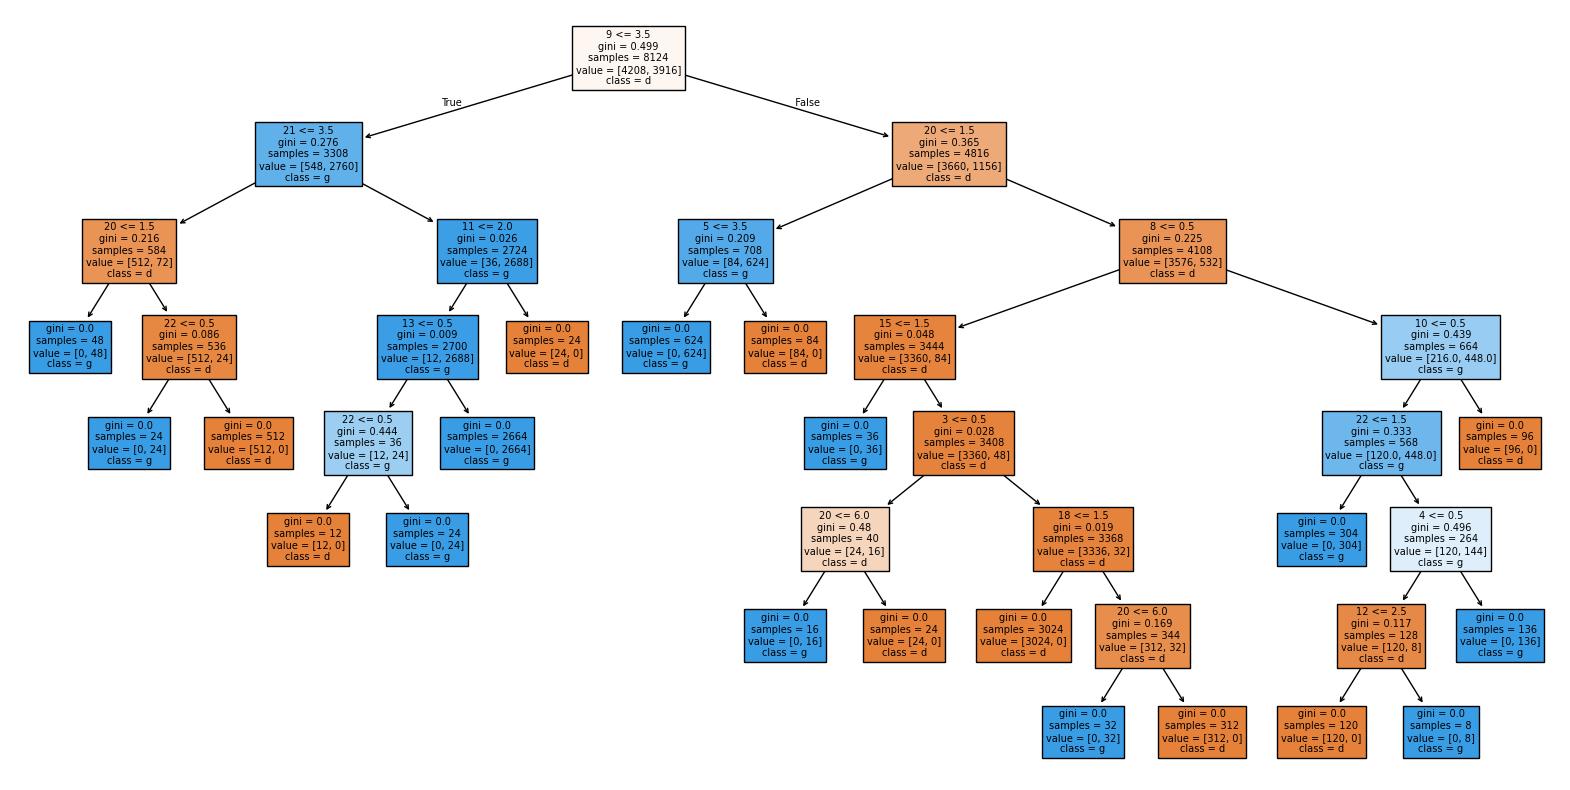

In [54]:
# Train the best tree with the optimal depth (you can select from the results above)
best_depth = 10  
best_clf = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
best_clf.fit(X, y)
plt.figure(figsize=(20, 10))
plot_tree(best_clf, filled=True, feature_names=X.columns, class_names=label_encoder.classes_)
plt.show()

## Before You Submit...

1. Re-read the general instructions provided above, and
2. Hit "Kernel"->"Restart & Run All".